# Section 1: Text Classification

## Text Classification With The Torchtext Library


### Access to the raw dataset iterators

In [1]:
import torch
from torchtext.datasets import AG_NEWS

In [2]:
AG_NEWS

<function torchtext.datasets.ag_news.AG_NEWS>

AG_NEWS consits of tupel of label and text.

In [3]:
train_iter = AG_NEWS(split='train')
print(f'example of AG_NEWs : {next(train_iter)}')
print(f'example of AG_NEWs : {next(train_iter)}')
print(f'example of AG_NEWs : {next(train_iter)}')

example of AG_NEWs : (3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
example of AG_NEWs : (3, 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')
example of AG_NEWs : (3, "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")


### Prepare data processing pipeline

In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter =  AG_NEWS(split='train')

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [5]:
# convert a list of tokens into integers
vocab(['here','is' ,'an', 'example'])

[475, 21, 30, 5297]

Let's build fuctions for process text and label. 

The text pipeline converts a text string into a list of integers based on the lookup table defined in the vocabulary. The label pipeline converts the label into integers

In [6]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) -1

In [7]:
text_pipeline('here is an example')

[475, 21, 30, 5297]

In [8]:
label_pipeline('10')

9

### Generate data batch and iterator

In [9]:
from torch.utils.data import DataLoader

def collate_batch(batch):
  label_list, text_list, offsets = [], [], [0]

  for (_label, _text) in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    offsets.append(processed_text.size(0))
  label_list = torch.tensor(label_list, dtype=torch.int64)  
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  text_list = torch.cat(text_list)
  return label_list, text_list, offsets

In [10]:
train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [11]:
print(f'length of train_iter is : {len(train_iter)} and length of dataloader is : {len(dataloader)}')

length of train_iter is : 120000 and length of dataloader is : 15000


Let's take a look at a batch of the dataloader.

In [12]:
examples = iter(dataloader)
#unpack examples
label, text , offset = examples.next()
print(f'label shape : {label.shape} ,text shape : {text.shape}, length of offset : {len(offset)}')
print(f'offset -> {offset}')
print(f'length of the first text in the batch : {offset[1]}')

label shape : torch.Size([8]) ,text shape : torch.Size([338]), length of offset : 8
offset -> tensor([  0,  29,  71, 111, 151, 194, 242, 289])
length of the first text in the batch : 29


Offset is a list with a length of 9(batch size + 1) that stores the length of each text in the batch.

### Define the model

In [13]:
from torch import nn

class TextClassificationModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_class):
    super(TextClassificationModel, self).__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
    self.fc = nn.Linear(embed_dim, num_class)
    self.init_weights()

  def init_weights(self):
    initrange = 0.5
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.fc.weight.data.uniform_(-initrange, initrange)
    self.fc.bias.data.zero_()

  def forward(self, text, offsets):
    embedded = self.embedding(text, offsets)
    return self.fc(embedded)  


### Initiate an instance

In [14]:
train_iter = AG_NEWS(split='train')
labels = [label for (label, text) in train_iter]

In [15]:
classes = set(labels)

distribution = {}
for i in classes:
  distribution[i] = labels.count(i)

print(f'distribution in each class : {distribution}')

distribution in each class : {1: 30000, 2: 30000, 3: 30000, 4: 30000}


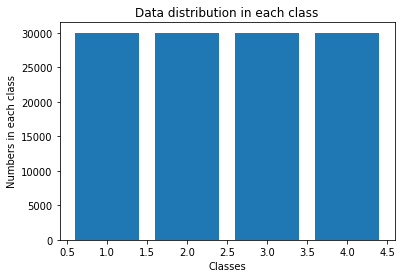

In [16]:
import matplotlib.pyplot as plt

num_in_class = [distribution[i] for i in range(1,5)]
plt.bar([1,2,3,4], num_in_class)
plt.xlabel('Classes')
plt.ylabel('Numbers in each class')
plt.title('Data distribution in each class')
plt.show()

In [17]:
num_class = len(classes)
vocab_size = len(vocab)
embed_dim = 64

model = TextClassificationModel(vocab_size, embed_dim, num_class)

### Define functions to train the model and evalute results

In [18]:
import time 

def train(dataloader):
  model.train()
  total_acc, total_count = 0, 0
  log_interval = 500
  start_time = time.time()

  for idx, (label, text, offsets) in enumerate(dataloader):

    predicted_label = model(text, offsets)
    loss = criterion(predicted_label, label)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) ####
    optimizer.step()

    total_acc += (predicted_label.argmax(1) == label).sum().item()
    total_count += label.size(0)

   
    if idx % log_interval == 0 and idx > 0:
      elapsed = time.time() - start_time
      print('| epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f}'.format(epoch, idx, len(dataloader), total_acc/total_count))

      total_acc, total_count = 0, 0
      start_time = time.time()  
    

def evaluate(dataloader):
  model.eval()
  total_acc , total_count = 0, 0
  
  with torch.no_grad():
    for idx, (label, text, offsets) in enumerate(dataloader):
      predicted_label = model(text, offsets)
      loss = criterion(predicted_label, label)
      total_acc += (predicted_label.argmax(1) == label).sum().item()
      total_count += label.size(0)
    return total_acc/total_count


### Split the dataset and run the model

In [19]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

epochs = 10
learning_rate = 5
batch_size = 64

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

In [20]:
train_iter, test_iter= AG_NEWS()

In [21]:
print(f'length of train iter : {len(train_iter)}')
print(f'length of test iter : {len(test_iter)}')

length of train iter : 120000
length of test iter : 7600


In [22]:
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

In [23]:
train_dataset[0]

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [24]:
test_dataset[0]

(3,
 "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.")

In [25]:
# split train_data set into train(0.95) and valid(0.05)
num_train = int(len(train_dataset)*0.95)

split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [26]:
print(f'length of split train : {len(split_train_)}')
print(f'length of split valid : {len(split_valid_)}')

length of split train : 114000
length of split valid : 6000


In [27]:
train_dataloader = DataLoader(split_train_, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

valid_dataloader = DataLoader(split_valid_, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [28]:
print(f'length of train dataloader : {len(train_dataloader)}')
print(f'length of valid dataloader : {len(valid_dataloader)}')
print(f'length of test dataloader : {len(test_dataloader)}')

length of train dataloader : 1782
length of valid dataloader : 94
length of test dataloader : 119


#### Train the model

In [29]:
for epoch in range(1, epochs+1):
  epoch_start_time = time.time()
  train(train_dataloader)
  accu_val = evaluate(valid_dataloader)
  if total_accu is not None and total_accu > accu_val:
    scheduler.step()
  else:
    total_accu = accu_val
  print('-'*59)
  print('| end of epoch {:3d} | time : {:5.2f}s | valid accuracy {:8.3f}'.format(epoch, time.time() - epoch_start_time, accu_val))  

  print('-'*59)

| epoch   1 |   500/ 1782 batches | accuracy    0.684
| epoch   1 |  1000/ 1782 batches | accuracy    0.852
| epoch   1 |  1500/ 1782 batches | accuracy    0.876
-----------------------------------------------------------
| end of epoch   1 | time : 15.44s | valid accuracy    0.884
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.895
| epoch   2 |  1000/ 1782 batches | accuracy    0.898
| epoch   2 |  1500/ 1782 batches | accuracy    0.903
-----------------------------------------------------------
| end of epoch   2 | time : 15.03s | valid accuracy    0.900
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.915
| epoch   3 |  1000/ 1782 batches | accuracy    0.913
| epoch   3 |  1500/ 1782 batches | accuracy    0.913
-----------------------------------------------------------
| end of epoch   3 | time : 15.28s | valid accuracy    0.907
-------------------------------

### Evalute the model with test dataset

In [30]:
print('Cheking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Cheking the results of test dataset.
test accuracy    0.907


### Test on a random new

In [35]:
ag_news_label = {1: "World",
                 2: "Sports",
                 3: "Business",
                 4: "Sci/Tec"}

def predict(text, text_pipeline):
  with torch.no_grad():
    text = torch.tensor(text_pipeline(text))
    output = model(text, torch.tensor([0]))
    return output.argmax(1).item() + 1


In [36]:
ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

print(f'This is {ag_news_label[predict(ex_text_str, text_pipeline)]} news')

This is Sports news
